# Exercises Week 9: Temperature regulated gene expression

**Course**: [Topics in life sciences engineering](https://moodle.epfl.ch/enrol/index.php?id=17061) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2025-2026


This week's exercises are inspired by the work of [Gotic et al., 2015](http://genesdev.cshlp.org/content/30/17/2005), in which RNA levels, including pre-mRNA and mRNA (total RNA-seq), were measured in mouse NIH-3T3 fibroblasts after cells were switched from a warm to a colder temperature (38C° to 33C°), and vice versa (33C° to 38C°).
The experiments were conducted over multiple time points in an "*approach to steady-state*" design. The cold-inducible *Cirbp* gene was used as an example to examine the kinetics and mechanisms of post-transcritional control of gene expression.

## Setup the Jupyter environment 
In order to run this notebook, we advise you to use the EPFL's JupyterLab centralized platform [noto.epfl.ch](http://noto.epfl.ch). Some of the required libraries are not available on the platform but you can install them copy-pasting the following commands in the **Jupyter Terminal** (open a new tab with the '+' icon and select "Terminal"):

````
my_venvs_create Week9_env
my_venvs_activate Week9_env
pip install adjustText
my_kernels_create Week9_env “Week9”
my_venvs_deactivate
````
Refresh your browser's page and select $\textbf{\color{red}the "Week9" kernel}$ using the top right toggle button. Import the libraries running the code cell below.

In [1]:
## Import libraries
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from scipy.integrate import odeint

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from adjustText import adjust_text


### Note: in those exercises we provide example code to guide you, but you should feel free to use your own if this is more conveneient for you.

## **Temperature regulates splicing efficiency of the cold-inducible RNA-binding protein gene *Cirbp***
This week’s exercises are based on the work of [Gotic et al., 2015](http://genesdev.cshlp.org/content/30/17/2005), which explores how core body temperature (CBT) rhythms influence gene expression, focusing on the role of the protein Cirbp.

In mammals, core body temperature (CBT) fluctuates along the day/night cycle by about one degree (slightly less in humans than mice) in the range of 36°C–37°C.

The paper investigates how CBT rhythms might synchronize gene expression, possibly through temperature-sensitive proteins. One such protein, Cirbp (Cold-Inducible RNA-Binding Protein), shows increased mRNA levels at lower temperatures. The authors aim to understand the mechanisms behind this temperature-sensitive response.

They explore different ways mRNA regulation could change with temperature, including:
- Increased Cirbp transcription at lower temperatures
- Reduced degradation of Cirbp mRNA at lower temperatures
- Enhanced pre-mRNA splicing efficiency at lower temperatures
  
Through various experiments (RNase protection assays, ChIP assays, luminescence assays), the authors rule out transcriptional and degradation regulation, showing that increased pre-mRNA splicing efficiency is key to the higher Cirbp mRNA accumulation at lower temperatures.

**Experimental design**
In these exercises, we will focus on one of the experiments that led to this conclusion. The authors used an “approach to steady-state” (ATSS) RNA-seq technique to examine genome-wide transcription and mRNA accumulation after temperature changes.  Specifically, NIH3T3 cells were exposed to a temperature change (either from 33°C to 38°C or from 38°C to 33°C) and collected at various time points after the shift. Total RNA was then extracted, ribosomal RNA was removed, and cDNA libraries were sequenced. This method enabled the authors to measure both pre-mRNA and mRNA levels across the entire genome.

<img src="./Experiment.png" alt="Alt text" width="50%"/>

## Exercise 1: Simulation of a simplified production-decay ODE model of transcription

We first consider a system in which nuclear pre-mRNA is transcribed and subsequently spliced to produce mRNA.  
Both molecular species are subject to distinct degradation processes, which can be modeled with a two-dimensional system of ordinary differential equations (ODEs):

\begin{aligned}
&\frac{dP}{dt} = s - (k_p + \rho)P \\
&\frac{dM}{dt} = \rho P - k_m M \\
\end{aligned}

where $P$ and $M$ represent the concentrations of pre-mRNA and mRNA, respectively.

Here, $s$ the transcription rate, is assumed to be a constant, but could also be a time-dependent function $s(t)$ (this will be explored further in the exercise session for Week 11).  
The parameters $k_m$ and $k_p$ are the degration rates of $M$ and $P$, respectively, while $\rho$ is the splicing rate of pre-mRNA $P$ into mRNA $M$; these rates are also constants.  
When all parameters are constant, the system will reach steady-state levels after a transient period, meaning that the derivatives $\frac{dP}{dt}$ and $\frac{dM}{dt}$ will equal to zero.

### Question 1
1. Derive the steady-state concentrations and interpret what happens to $M$ when $\rho\gg k_p$.  

2. Compute the steady-state ratio mRNA/pre-mRNA.   
    a. Comment on the result, in particular discuss which parameters are important and which are not.  
    b. Discuss how this ratio might be used to compare mRNA half-lives across different conditions.

3. Using $\rho = 2 h^{-1}$, $s = 1 [\text{P}]h^{-1}$ and $k_m = 0.1 h^{-1}$ (values from litterature), estimate the ratio of mRNA to pre-mRNA molecules in typical mammalian cells.

### Answer 1

**1.** At steady-sate, $\frac{dP}{dt}=\frac{dM}{dt}$=0, therefore:  
\begin{aligned}
&P = \frac{s}{(k_p + \rho)} \\
&M = \frac{s}{k_m}\frac{\rho}{(k_p + \rho)} \\
\end{aligned}  
When $\rho\gg k_p$, M depends only on the synthesis and degradation rate $s$ and $k_m$, respectively, as the term $\frac{\rho}{(k_p + \rho)}$ approximates to 1.
 
**2.**  

  - **a.** The steady-state ratio $\frac{M}{P}=\frac{\rho}{k_m}$ depends only on the splicing rate $\rho$ and the degradation rate of the mRNA, $k_m$.
  - **b.** Measuring the ratio mRNA/pre-mRNA (*e.g.* using RNA-seq exon/intron count) allows for comparison of mRNA half-life or splicing rate across different conditions, depending on the hypothesis.  

**3.** The ratio $\frac{M}{P}=\frac{\rho}{k_m}$ = $\frac{2}{0.1}$ = 20, indicating that there are around 20 times more mRNA molecules than pre-mRNA molecules in typical mammalian cells at steady-state.








### Question 2 
Simulate the production-decay ODE with a constant transcription rate $s$ using the provided code:
1. Using the interactive widget (read the code below), describe the effects obtained by varying parameters such as splicing rate ($\rho$), degradation rates ($k_p$ and $k_m$) and transcription rate ($s$).\
Experiment with different initial conditions for the pre-mRNA and mRNA concentrations as well.

2. Adapt the code by adding a few lines to plot the steady-state concentrations of pre-mRNA and mRNA, as derived in Question 1.1. 

3. Optional: Extend the model by incorporating a third differential equation that represents the protein level (G). Update the simulation and the corresponding plots to include protein dynamics. How similar/different is the relation between P and M compared to the one between M and G ?

Remember to clearly label all axes and legends on your plots for easy interpretation.

### Answer 2  

1. As $s$ gets larger, both P and M become larger, since more new transcripts enter the system. When $k_p$ becomes larger, both P and M get reduced, since more pre-mRNA is degraded per unit of time. When $k_m$ becomes larger, only concentration of mRNA is reduced, not impacing P. The larger $\rho$ becomes, the more reduced is P and the more increased is M. Larger $\rho$ means that more pre-mRNA molecules are spliced into mRNA per unit of time.

   
2. *See code below*  


3. We can add one more differential equation to describe the protein dynamic:  

\begin{aligned}
&\frac{dG}{dt}= \tau M - k_gG
\end{aligned}

where $G$ is the concentration of the protein, $\tau$ the protein synthesis rate and $k_g$ the degradation rate of the protein. See code below.\
Similarity: When P increases, M increases as well, just like when M increases G also increases (until saturation).\
Difference: 1 pre-mRNA is spliced to become 1 mRNA, so there is a stoichiometric ratio of 1. In the contrary, 1 mRNA can give rise to multiple protein units, thus in this model production of 1 protein unit does not cause diminution of M.



#### Definition of important functions


In [9]:
def production_decay_ode(y, time, s, kp, km, rho, tau, kg):

    """
    Defines the ODEs for the production and decay of pre-mRNA and mRNA.
    P: pre-mRNA concentration
    M: mRNA concentration
    s: transcription rate (constant)
    kp: pre-mRNA degradation rate
    km: mRNA degradation rate
    rho: splicing rate
    tau: protein synthesis rate
    kg: protein degradation rate
    """
    
    P, M, G = y
    dPdt = s - (kp + rho) * P
    dMdt = rho * P - km * M
    dGdt = tau * M - kg * G
    return [dPdt, dMdt, dGdt] 


def simulation(ode_function, parameters, initial_conditions = None, time = None):

    """
    Simulate the ODEs for the production and decay of pre-mRNA and mRNA.
    parameters: parameters for the ODEs
    initial_conditions: initial conditions for the ODEs
    time: time intervals for the simulation
    """

    s = parameters['s']
    kp = parameters['kp']
    km = parameters['km']
    rho = parameters['rho']
    tau = parameters['tau']
    kg = parameters['kg']

    # Placeholder for adding steady-state solutions

    P_ss = s / (kp + rho) #Add your steady-state solution for P here 
    M_ss = (s / km) * (rho / (kp + rho)) #Add you steady-state solution for M here
    
    results = odeint(ode_function, initial_conditions, time, args=(s, kp, km, rho, tau, kg))

    plt.figure(figsize=(10, 6))
    plt.ylim([0,150])

    # Uncomment the lines below after adding your steady-state solutions
    plt.axhline(y=P_ss, color='blue', linestyle='--', label='P_ss')  
    plt.axhline(y=M_ss, color='orange', linestyle='--', label='M_ss')

    plt.title('Simulation of pre-mRNA and mRNA Production-Decay Dynamics')
    plt.plot(time, results[:, 0], label = 'P(t)', linewidth=2)
    plt.plot(time, results[:, 1], label = 'M(t)', linewidth=2)
    plt.xlabel("Time [min]")
    plt.ylabel("Concentration")
    plt.legend()

    plt.twinx()
    plt.plot(time, results[:, 2], label = 'G(t)', linewidth=2, color='green') 
    plt.ylim([0,4000])

    plt.xlabel("Time [min]")
    plt.ylabel("Concentration")
    plt.legend(loc='upper left')
    plt.show()
    
def animate(initial_conditions, time, s=5, kp= 0.05, km=0.05, rho=0.4, tau=0.04, kg=0.016):
    """
    Runs the simulation with an interactive widgets for parameter exploration.
    """
      
    parameters = {'s':s,'kp':kp, 'km':km, 'rho':rho, 'tau':tau, 'kg':kg}
    simulation(production_decay_ode, parameters, initial_conditions, time)


#### Run the simulation

In [3]:

# Define initial conditions and time intervals for the simulation
initial_conditions = [0, 0, 0] #[P, M, G]
time = np.linspace(0, 500, 10001)

interact(animate, 
         initial_conditions=fixed(initial_conditions), 
         time=fixed(time), 
         s = (1,10,0.01), #  Transcription rate units: concentration [P] per min    
         kp = (1/120,1/10,1/1000), # Pre-mRNA degradation rate units: 1/min (range: 10 min to 120 min)
         km = (1/600,1/10,1/1000),  # mRNA degradation rate units: 1/min (range: 10 min to 600 min)
         rho = (1/30,1,0.05), #splicing rate units: 1/min (range: 1 min to 30 min)
         tau = (1/30,1,1/100), #unit of tau is number of proteins per min per molecules of M [1/30 min^-1, 1 min^-1]
         kg = (1/(24 * 60), 1/60,1/1000)); #kg^-1 in [60min, 24*60min]

interactive(children=(FloatSlider(value=5.0, description='s', max=10.0, min=1.0, step=0.01), FloatSlider(value…

## Exercise 2: RNA-seq analysis and modelling of gene expression response to temperature up- and down-shifts

In [Gotic et al., 2015](http://genesdev.cshlp.org/content/30/17/2005), cells were harvested at various time points (0, 1, 3, 6, and 9 hours) after a temperature switch from 33°C to 38°C and vice versa, with duplicates subjected to total RNA-seq analysis. The resulting data were processed to assign reads to pre-mRNA and mRNA species and to obtain their respective levels. Here, we will analyze those data to study and model gene expression responses to temperature shifts.

The functions provided below (run the cell) will assist you in the analysis.

#### Implementation of useful functions

In [4]:
def run_PCA(data, n_components=5, color_by='replicate', symbol_by='time', scale_data=True, log_transform=False):
    
    """
    Runs PCA on the provided data and generates a scatter plot of pairs of principal components.
    It also returns a DataFrame containing the PCA loadings.

    Parameters:
    data: The gene expression data to analyze.
    n_components: The number of principal components to calculate.
    color_by: The metadata category to color the data points by.
    symbol_by: The metadata category to symbolize the data points by.
    scale_data: Whether to scale the data before PCA.
    log_transform: Whether to apply log transformation to the data.

    Returns:
    pd.DataFrame: A DataFrame containing the PCA loadings.
    """

    data_pca = data.copy()

    if log_transform:
        data_pca=np.log2(data_pca+1)

    data_pca = data_pca.T
    if scale_data:
        data_pca = scale(data_pca, axis=0) # this scales the columns (genes)

    # Fit the PCA model
    pca = PCA(n_components=n_components)
    pca.fit(data_pca)

    # Transform the data
    pca_transformed = pca.transform(data_pca)

    # Create a DataFrame for the PCA results
    labels = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(pca_transformed, columns=labels)
    if color_by=='time':
        pca_df[color_by] = pd.to_numeric(data.columns.get_level_values(color_by))
        palette='viridis'
    else:
        pca_df[color_by] = data.columns.get_level_values(color_by)
        palette='Set1'
    pca_df[symbol_by] = data.columns.get_level_values(symbol_by)

    # Plotting each pair of consecutive principal components
    fig, axes = plt.subplots(1, n_components -1, figsize=(30, 5))
    for i in range(n_components-1):
        sns.scatterplot(ax=axes[i], data=pca_df, x=f'PC{i+1}', y=f'PC{i+2}', 
        hue=color_by, style=symbol_by, s=200, palette=palette) 

        axes[i].set_xlabel(f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.2f}%)')
        axes[i].set_ylabel(f'PC{i+2} ({pca.explained_variance_ratio_[i+1]*100:.2f}%)')
        # remove legend if it's not the first plot
        if i != 0:
            axes[i].get_legend().remove()
    
    fig.suptitle(f'PCA of Gene Expression Data (color={color_by}, symbol={symbol_by})', fontsize=16)

    # Return the PCA loadings
    df_pca = pd.DataFrame(pca.components_, columns=data.index, index=labels)

    return df_pca


## Plot Gene profile across all conditions
def plot_gene(data, gene , xx_33_38=None, xx_38_33=None, t_2=None):

    """
    Plots the gene expression profile across different conditions and time points.
    
    Parameters:
    data: The gene expression data.
    gene: The gene to plot.
    xx_33_38: The simulated solution for the 33to38 condition.
    xx_38_33: The simulated solution for the 38to33 condition.

    Returns:
    None
    """

    #subselect
    time= ['0', '1' ,'3' ,'6', '9']
    replicate = ['2', '13', '11', '5']
    idx=pd.IndexSlice
    dat_1= data.loc[:, idx['33to38', time, replicate, 'intron']]
    dat_2= data.loc[:, idx['33to38', time, replicate, 'exon']]
    dat_3= data.loc[:, idx['38to33', time, replicate, 'intron']]
    dat_4= data.loc[:, idx['38to33', time, replicate, 'exon']]


    #plot
    t=np.array([0, 0, 1, 1, 3, 3, 6, 6, 9 , 9])
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=False)
    #fig.subplots_adjust(wspace=0.25)
    axs[0, 0].scatter(t, dat_1[dat_1.index.str.endswith(gene)].values.T, c = [0,2]*5, vmin=0, vmax=3, label='intron 33to38') #color is replicate
    axs[0, 0].set_title("intron 33to38")
    
    axs[1, 0].scatter(t, dat_2[dat_2.index.str.endswith(gene)].values.T, c = [0,2]*5, vmin=0, vmax=3,  label='exon 33to38') #color is replicate
    axs[1, 0].set_title("exons 33to38")
    
    axs[0, 1].scatter(t, dat_3[dat_3.index.str.endswith(gene)].values.T, c = [1,3]*5, vmin=0, vmax=3, label='intron 38to33') #color is replicate
    axs[0, 1].set_title("intron 38to33")

    axs[1, 1].scatter(t, dat_4[dat_4.index.str.endswith(gene)].values.T, c = [1,3]*5, vmin=0, vmax=3,  label='exon 38to33') #color is replicate
    axs[1, 1].set_title("exon 38to33")

    y_lim_max_intron=max([axs[0,0].get_ylim()[1], axs[0,1].get_ylim()[1]])
    y_lim_max_exon=max([axs[1,0].get_ylim()[1], axs[1,1].get_ylim()[1]])
    y_lim_min_intron=min([axs[0,0].get_ylim()[0], axs[0,1].get_ylim()[0]])
    y_lim_min_exon=min([axs[1,0].get_ylim()[0], axs[1,1].get_ylim()[0]])
    axs[0,0].set_ylim(y_lim_min_intron, y_lim_max_intron)
    axs[0,1].set_ylim(y_lim_min_intron, y_lim_max_intron)
    axs[1,0].set_ylim(y_lim_min_exon, y_lim_max_exon)
    axs[1,1].set_ylim(y_lim_min_exon, y_lim_max_exon)
    if xx_33_38 is not None:
        axs[0,0].plot(t_2, xx_33_38[:,0],label = 'P(t)', color="tab:orange")
        axs[1,0].plot(t_2, xx_33_38[:,1], color="tab:orange")
        axs[0,1].plot(t_2, xx_38_33[:,0], color="tab:orange")
        axs[1,1].plot(t_2, xx_38_33[:,1], color="tab:orange")
    
        
    for ax in axs.flat:
        ax.set(xlabel='Time [h]', ylabel='RPKM')

    fig.suptitle(f'Gene Expression Profile for {gene}', fontsize=16)
    plt.show()

def plot_DE(dat_all, condition_x1, condition_x2, condition_y1, condition_y2, time_x1, time_x2, time_y1, time_y2, feature_x1, feature_x2, feature_y1, feature_y2, FC=2, xlab="", ylab="", FC_type="delta"):
    
    """
    Plots differentially expressed genes based on log fold changes between specified conditions, times, and features.

    Parameters:
    dat_all: The complete dataset with gene expression values.
    condition_x1, condition_x2, condition_y1, condition_y2: Lists of conditions to compare.
    time_x1, time_x2, time_y1, time_y2: Lists of time points to compare.
    feature_x1, feature_x2, feature_y1, feature_y2: Lists of features to compare.
    FC: Absolute fold change threshold for considering a gene differentially expressed in at least one of the two axes.
    xlab: Label for the x-axis representing the log fold change between condition_x2 and condition_x1.
    ylab: Label for the y-axis representing the log fold change between condition_y2 and condition_y1.

    Returns:
    Array: Boolean array indicating differentially expressed genes that meet the fold change threshold.
    """
     
    replicate = ['2', '13', '11', '5']

    idx=pd.IndexSlice    
    dat_x1=dat_all.loc[:, idx[condition_x1, time_x1, replicate, feature_x1]].mean(axis=1)
    dat_x2=dat_all.loc[:, idx[condition_x2, time_x2, replicate, feature_x2]].mean(axis=1)
    dat_y1=dat_all.loc[:, idx[condition_y1, time_y1, replicate, feature_y1]].mean(axis=1)
    dat_y2=dat_all.loc[:, idx[condition_y2, time_y2, replicate, feature_y2]].mean(axis=1)

    x=np.log2(1 + dat_x2)- np.log2(1 + dat_x1)
    y=np.log2(1 + dat_y2) - np.log2(1 + dat_y1)

    if FC_type == "delta":
        pos =((x > FC) & (y > FC)) | ((x < -FC) & (y < -FC))

    if FC_type == "delta_delta":
        pos = abs(x-y) > FC

    x_2 = x[pos]
    y_2 = y[pos]
    fig, ax = plt.subplots(figsize=(10,10))

    ax.plot(x,y, 'o', color = 'lightblue', markersize=2)
    ax.axhline(y=0, color='b')
    ax.axvline(x=0, color='b')
    ax.set_xlim(-8,8)
    ax.set_ylim(-8,8)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    texts = [ax.text(x_2.iloc[k], y_2.iloc[k], v.split("|")[1]) for k, v in enumerate(dat_all.index[pos])]
    adjust_text(texts)
    
    return(pos)    


###  Question 1

**PCA** (Read carefully)

*"Principal Component Analysis (PCA) is a dimensionality reduction technique that simplifies complex datasets by transforming them into a set of orthogonal axes, or principal components (PCs), that summarize the underlying patterns of variation. It works by calculating the eigenvectors and eigenvalues from the covariance matrix of the data, which then define the new axes. The first principal component captures the largest amount of variance in the data, with each subsequent component—perpendicular to the last—capturing progressively less variance. This orthogonal nature of PCA ensures that each component adds distinct information. This means that all the PCs are uncorrelated to each other. When applied to gene expression data, PCA reduces the numerous gene variables to a few composite indicators without losing critical information. After transformation, each principal component represents a combination of genes. The loadings of these components then tell us about the contribution of each gene to the component. Genes with high absolute loadings have a greater role in defining the structure revealed by that component, allowing us to identify which genes are most responsible for differentiating the samples on the basis of the observed variance."*
  
  
Using the provided code below, explore the RNA-Seq data:

1. Perform principal component analysis (PCA) selecting different temperature conditions, time points, replicates and features (i.e. intron or exon). For each scenario described below, explore the principal components (PCs) and comment your findings.
  
    a. With all samples included, determine the primary sources of variance. Is there an outlier? Do replicates cluster as expected?  
    b. Focus on exonic counts and identify which principal component correlates with time.  
    c. In the PCA representation, describe the transcriptome response over time. Are there notable differences between the two conditions? 

*Modify only the code marked as 'PCA' below*.

#### Load the RNA-seq data (normalized counts) and format it as a panda data.frame


In [5]:
#Load 33to38 data
dat_33_38 = pd.read_csv("./GoticData/GSE85553_33-38_exon_intron_RPKM.txt",sep='\t')
dat_33_38=dat_33_38.add_prefix("33to38.")

#Load 33to38 data
dat_38_33 = pd.read_csv("./GoticData/GSE85553_38-33_exon_intron_RPKM.txt",sep='\t')
dat_38_33=dat_38_33.add_prefix("38to33.")
dat_33_38

,33to38.t0.13.exon,33to38.t0.13.intron,33to38.t0.2.exon,33to38.t0.2.intron,33to38.t1.13.exon,33to38.t1.13.intron,33to38.t1.2.exon,33to38.t1.2.intron,33to38.t3.13.exon,33to38.t3.13.intron,33to38.t3.2.exon,33to38.t3.2.intron,33to38.t6.13.exon,33to38.t6.13.intron,33to38.t6.2.exon,33to38.t6.2.intron,33to38.t9.13.exon,33to38.t9.13.intron,33to38.t9.2.exon,33to38.t9.2.intron
ENSMUSG00000090025|Gm16088,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
ENSMUSG00000064842|U6,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
ENSMUSG00000051951|Xkr4,0.00000,1.972758,0.000000,7.955391,0.000000,3.763305,0.000000,1.941199,0.000000,3.900310,0.000000,2.955923,0.000000,4.948684,0.000000,1.870000,0.000000,0.00000,0.000000,1.958227
ENSMUSG00000089699|Gm1992,0.00000,0.000000,0.000000,0.980092,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.980756
ENSMUSG00000088390|U7,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000095366|G530011O06RIK,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
ENSMUSG00000095134|MID1,0.00000,0.099717,0.000000,0.421000,0.668199,0.752801,0.668199,0.833418,0.787154,0.212846,1.787154,0.732038,0.000000,0.000000,1.653161,0.753322,0.000000,0.00000,2.196831,1.841554
ENSMUSG00000096768|ERDR1,257.65883,114.988899,276.444591,100.532857,194.273330,76.384483,349.182851,92.670999,159.913652,70.993066,272.942180,69.987442,114.188928,60.940200,225.131671,76.438960,114.897537,51.25415,268.310444,89.687251
ENSMUSG00000096850|G530011O06RIK,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [6]:
#concatenate
dat_all = pd.concat([dat_33_38, dat_38_33.iloc[:, :20]],axis=1)
dat_all.columns=dat_all.columns.str.replace('\\.t','.', regex=True)
# dat_all.replace([np.inf, -np.inf], 0, inplace=True)

#create column names
dat_all.columns=dat_all.columns.str.split('.', expand = True)
dat_all.columns.names = ['condition','time','replicate','feature']
dat_all

condition                            33to38                          \
time                                      0                           
replicate                                13                       2   
feature                                exon      intron        exon   
ENSMUSG00000090025|Gm16088          0.00000    0.000000    0.000000   
ENSMUSG00000064842|U6               0.00000    0.000000    0.000000   
ENSMUSG00000051951|Xkr4             0.00000    1.972758    0.000000   
ENSMUSG00000089699|Gm1992           0.00000    0.000000    0.000000   
ENSMUSG00000088390|U7               0.00000    0.000000    0.000000   
...                                     ...         ...         ...   
ENSMUSG00000095366|G530011O06RIK    0.00000    0.000000    0.000000   
ENSMUSG00000095134|MID1             0.00000    0.099717    0.000000   
ENSMUSG00000096768|ERDR1          257.65883  114.988899  276.444591   
ENSMUSG00000096850|G530011O06RIK    0.00000    0.000000    0.000000   
ENSMUSG00000095326|AC151712.1       0.00000    0.000000    0.000000   

condition                                                            \
time                                                   1              
replicate                                             13              
feature                               intron        exon     intron   
ENSMUSG00000090025|Gm16088          0.000000    0.000000   0.000000   
ENSMUSG00000064842|U6               0.000000    0.000000   0.000000   
ENSMUSG00000051951|Xkr4             7.955391    0.000000   3.763305   
ENSMUSG00000089699|Gm1992           0.980092    0.000000   0.000000   
ENSMUSG00000088390|U7               0.000000    0.000000   0.000000   
...                                      ...         ...        ...   
ENSMUSG00000095366|G530011O06RIK    0.000000    0.000000   0.000000   
ENSMUSG00000095134|MID1             0.421000    0.668199   0.752801   
ENSMUSG00000096768|ERDR1          100.532857  194.273330  76.384483   
ENSMUSG00000096850|G530011O06RIK    0.000000    0.000000   0.000000   
ENSMUSG00000095326|AC151712.1       0.000000    0.000000   0.000000   

condition                                                            \
time                                                              3   
replicate                                  2                     13   
feature                                 exon     intron        exon   
ENSMUSG00000090025|Gm16088          0.000000   0.000000    0.000000   
ENSMUSG00000064842|U6               0.000000   0.000000    0.000000   
ENSMUSG00000051951|Xkr4             0.000000   1.941199    0.000000   
ENSMUSG00000089699|Gm1992           0.000000   0.000000    0.000000   
ENSMUSG00000088390|U7               0.000000   0.000000    0.000000   
...                                      ...        ...         ...   
ENSMUSG00000095366|G530011O06RIK    0.000000   0.000000    0.000000   
ENSMUSG00000095134|MID1             0.668199   0.833418    0.787154   
ENSMUSG00000096768|ERDR1          349.182851  92.670999  159.913652   
ENSMUSG00000096850|G530011O06RIK    0.000000   0.000000    0.000000   
ENSMUSG00000095326|AC151712.1       0.000000   0.000000    0.000000   

condition                                    ...      38to33              \
time                                         ...           3               
replicate                                    ...           5               
feature                              intron  ...        exon      intron   
ENSMUSG00000090025|Gm16088         0.000000  ...    0.000000    0.000000   
ENSMUSG00000064842|U6              0.000000  ...    0.000000    0.000000   
ENSMUSG00000051951|Xkr4            3.900310  ...    0.000000    4.871782   
ENSMUSG00000089699|Gm1992          0.000000  ...    0.000000    0.000000   
ENSMUSG00000088390|U7              0.000000  ...    0.000000    0.000000   
...                                     ...  ...         ...         ...   
ENSMUSG00000095366|G530011O06RIK   0.00000

#### Keep expressed genes (i.e. genes with mean expression > 8 and > 128 RPKM in intron and exon quantification, respectively)


In [7]:
time= ['0', '1' ,'3' ,'6', '9']
replicate = ['2', '13', '11', '5'] # replicates 13 and 2 are from the 33to38 experiment, 5 and 11 from the 38to33.
condition = ['33to38','38to33']

idx = pd.IndexSlice
dat_intron = dat_all.loc[:, idx[condition, time, replicate, 'intron']]
dat_exon = dat_all.loc[:, idx[condition, time, replicate, 'exon']]

dat_all = dat_all.loc[(dat_intron.mean(axis=1) > 8 ) & (dat_exon.mean(axis=1) > 128), :]
dat_all

condition                        33to38                            \
time                                  0                             
replicate                            13                         2   
feature                            exon       intron         exon   
ENSMUSG00000033845|Mrpl15   2476.701058   936.152375  3241.777678   
ENSMUSG00000025903|Lypla1   3038.875023  1141.613249  1657.806253   
ENSMUSG00000033813|Tcea1    2613.049477  1724.892440  2887.682527   
ENSMUSG00000002459|Rgs20     340.018549  8380.093915   599.092980   
ENSMUSG00000033793|Atp6v1h  4665.133072  4311.653980  3980.198774   
...                                 ...          ...          ...   
ENSMUSG00000025742|Prps2    3116.147654  1056.389200  3255.310637   
ENSMUSG00000031358|Msl3     2161.911447   797.042986  1751.469389   
ENSMUSG00000031352|Hccs     1094.097773   505.807727   850.751712   
ENSMUSG00000035299|Mid1      146.728015  3376.517865   185.943064   
ENSMUSG00000096768|ERDR1     257.658830   114.988899   276.444591   

condition                                                           \
time                                                1                
replicate                                          13                
feature                           intron         exon       intron   
ENSMUSG00000033845|Mrpl15     985.166222  2104.681826   737.738308   
ENSMUSG00000025903|Lypla1     667.436330  2390.897657  1265.575643   
ENSMUSG00000033813|Tcea1     1438.604823  2260.151398  1432.495685   
ENSMUSG00000002459|Rgs20    13053.530231   272.144907  8593.741029   
ENSMUSG00000033793|Atp6v1h   2994.219345  3895.686890  4467.460172   
...                                  ...          ...          ...   
ENSMUSG00000025742|Prps2     1103.688177  2745.650867  1093.931933   
ENSMUSG00000031358|Msl3       565.120094  1940.959552   771.728948   
ENSMUSG00000031352|Hccs       311.897872   865.971683   437.146484   
ENSMUSG00000035299|Mid1      1830.610328    99.051485  2371.492972   
ENSMUSG00000096768|ERDR1      100.532857   194.273330    76.384483   

condition                                                           \
time                                                             3   
replicate                             2                         13   
feature                            exon        intron         exon   
ENSMUSG00000033845|Mrpl15   3808.370019   1046.504657  2262.017510   
ENSMUSG00000025903|Lypla1   2083.725985    930.791440  2269.966630   
ENSMUSG00000033813|Tcea1    3102.910645   1368.355017  2126.285149   
ENSMUSG00000002459|Rgs20     495.149427  13187.059827   269.416317   
ENSMUSG00000033793|Atp6v1h  4311.279608   3427.977325  3871.618538   
...                                 ...           ...          ...   
ENSMUSG00000025742|Prps2    3970.467044   1262.631840  2593.224590   
ENSMUSG00000031358|Msl3     2074.781350    639.025900  1999.207635   
ENSMUSG00000031352|Hccs     1005.873880    377.184903  1002.842226   
ENSMUSG00000035299|Mid1      173.543217   1237.818716    88.512249   
ENSMUSG00000096768|ERDR1     349.182851     92.670999   159.913652   

condition                                 ...       38to33                \
time                                      ...            3                 
replicate                                 ...            5                 
feature                           intron  ...         exon        intron   
ENSMUSG00000033845|Mrpl15     801.002057  ...  4201.965471   1119.864612   
ENSMUSG00000025903|Lypla1    1285.418203  ...  2235.290852    967.488632   
ENSMUSG00000033813|Tcea1     1559.814568  ...  3407.377422   2146.180917   
ENSMUSG00000002459|Rgs20    11802.215785  ...   420.576666  12592.995674   
ENSMUSG00000033793|Atp6v1h   4438.853755  ...  5115.216169   4445.208424   
...                                  ...  ...          ...           ...   
ENSMUSG00000025742|Prps2      922.374234  ...  3705.431517   1481.352033   
ENSMUSG00000031358|Msl3   

### PCA
#### Perform PCA selecting different temperature conditions, timepoints, replicate and features (intron vs. exon). Change those parameters to select different samples for the PCA.

### Answer 1

**1a.** The feature type (intron or exon) accounts for most of the variance in the data (PC1). Additionally, samples within each replicate cluster closely along along PC3. See code below.

In [8]:
#Choose the features, conditions, replicates, and time points to include in the analysis for the different questions.
condition = ['38to33','33to38']
time= ['0', '1' ,'3' ,'6', '9']
replicate = ['2', '13', '11', '5'] # replicates 13 and 2 are from the 33to38 experiment, 5 and 11 from the 38to33.
feature = ['intron', 'exon']

#Subselect the samples 
dat_sub = dat_all.loc[:, idx[condition, time, replicate, feature]]
dat_sub
dat_sub.columns.get_level_values('feature')

Index(['intron', 'exon', 'intron', 'exon', 'intron', 'exon', 'intron', 'exon',
       'intron', 'exon', 'intron', 'exon', 'intron', 'exon', 'intron', 'exon',
       'intron', 'exon', 'intron', 'exon', 'intron', 'exon', 'intron', 'exon',
       'intron', 'exon', 'intron', 'exon', 'intron', 'exon', 'intron', 'exon',
       'intron', 'exon', 'intron', 'exon', 'intron', 'exon', 'intron', 'exon'],
      dtype='object', name='feature')

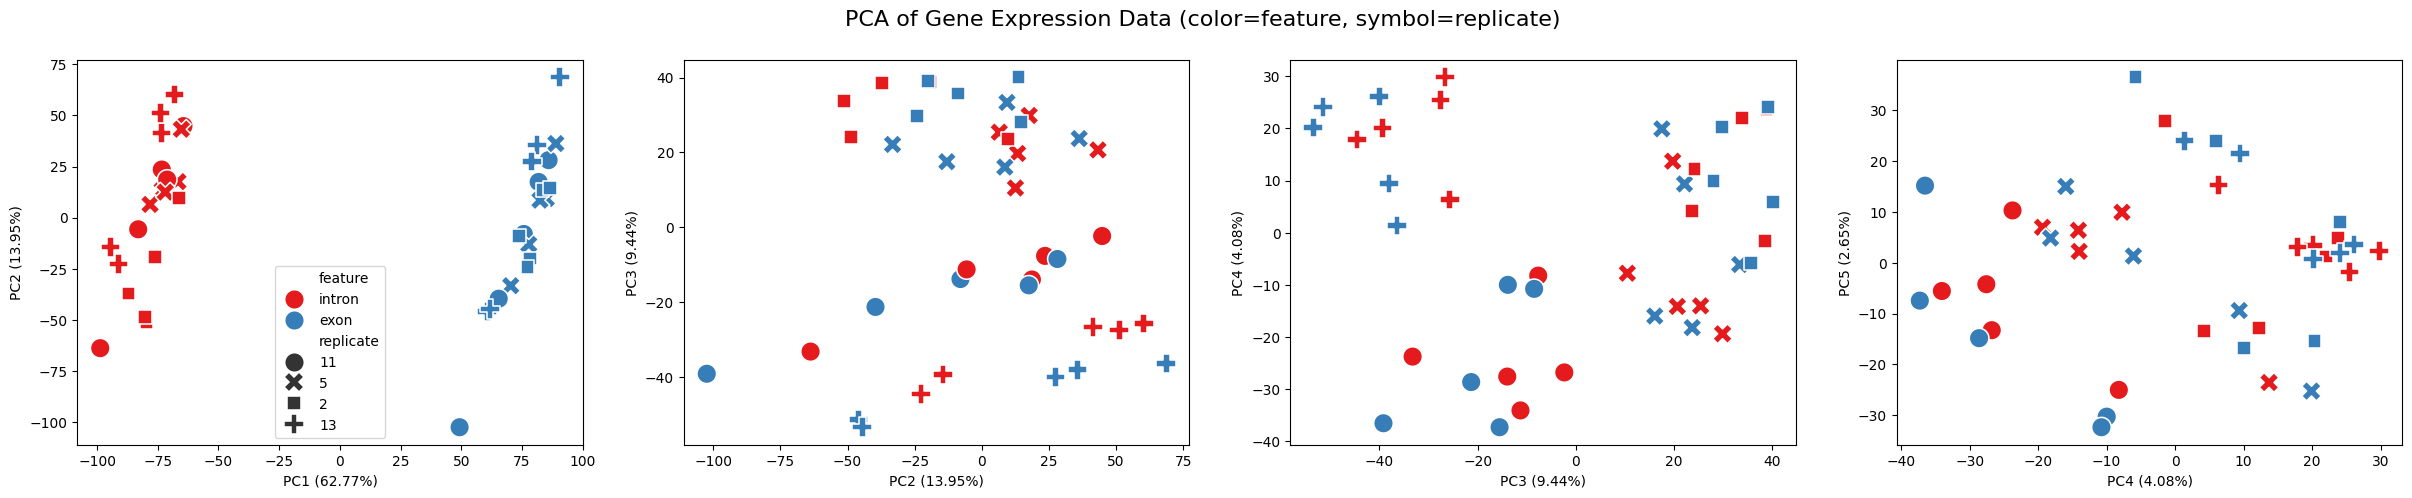

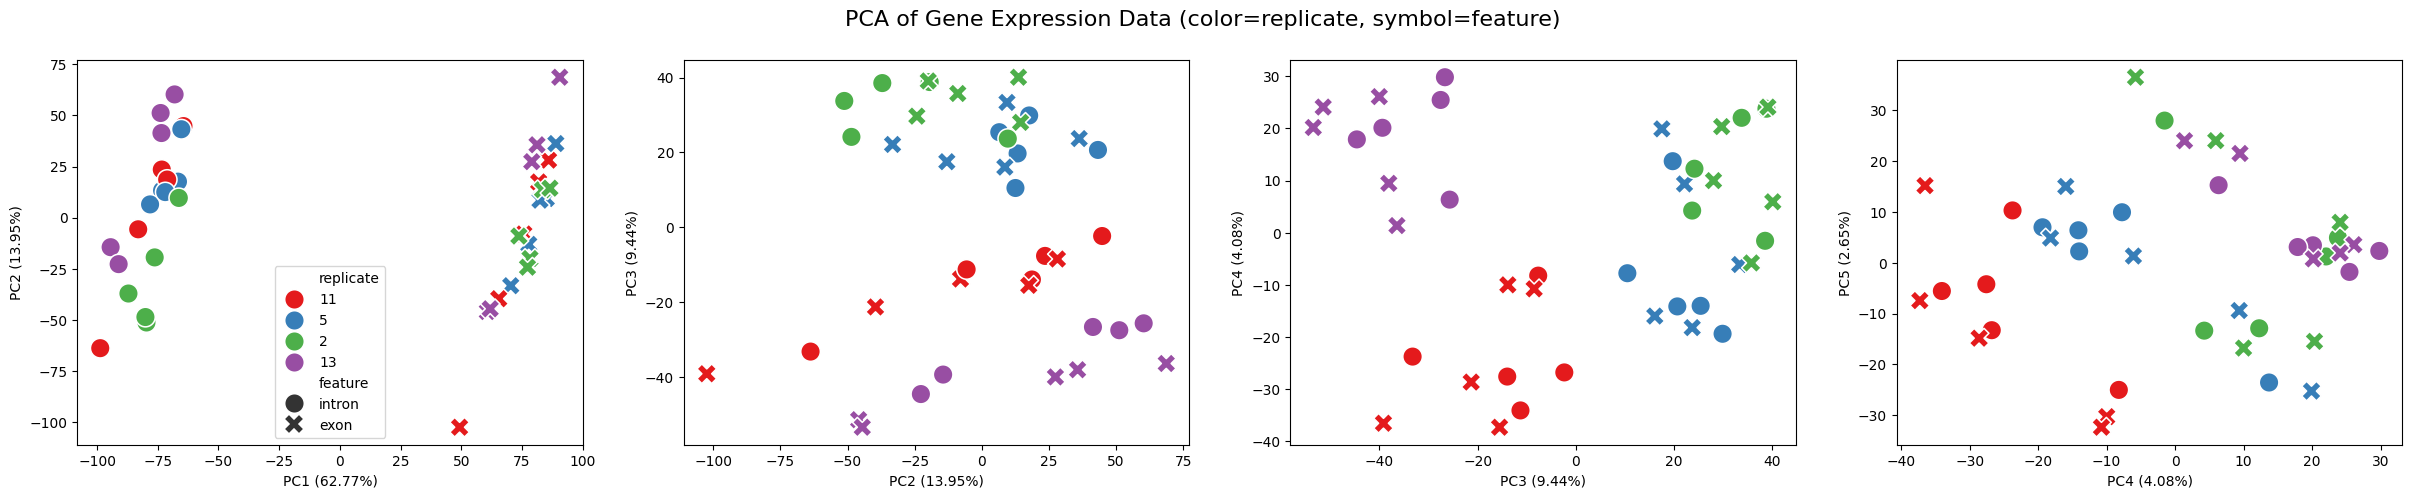

In [37]:
#Perform the PCA, plot, and return the PCA loadings. Adjust the parameters color_by and symbol_by to answer to the different question.
PC_loadings_all = run_PCA(dat_sub, n_components=5, color_by='feature', symbol_by='replicate', scale_data=True, log_transform=True)
run_PCA(dat_sub, n_components=5, color_by='replicate', symbol_by='feature', scale_data=True, log_transform=True);

**1b.** In the PC1 vs. PC2 plot, there is clustering by replicate and condition, except for one samples from replicate "5" (condition 38to33) that cluster with samples from replicate "2" (condition 33to38). Time seems to correlate with PC4 for most samples. The samples are arranged according to time; for the 33to38 condition, time increases along PC4, and for the 38to33 condition, it decreases. 

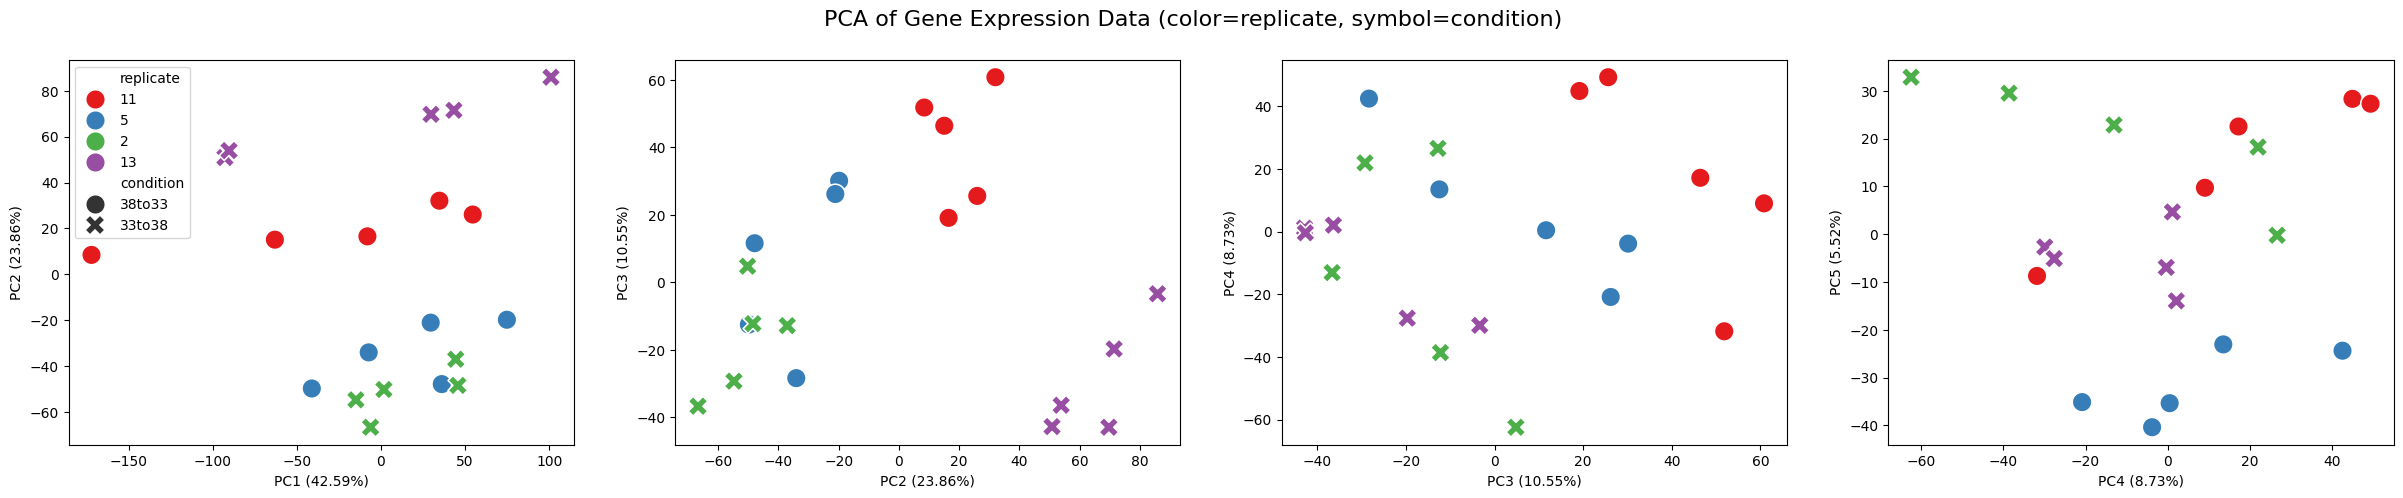

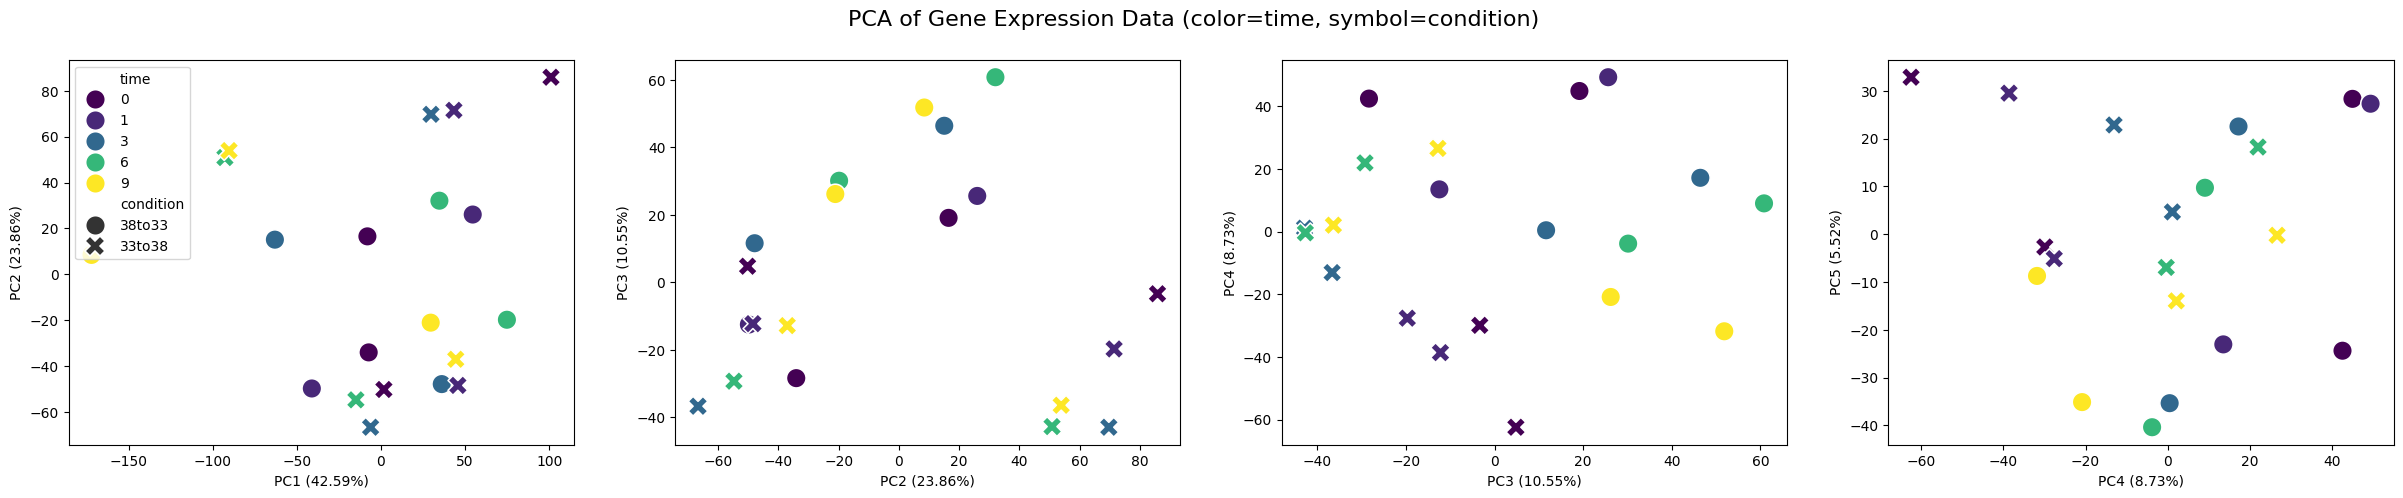

In [38]:
#Choose the features, conditions, replicates, and time points to include in the analysis for the different questions.
condition = ['38to33','33to38'] 
time= ['0', '1' ,'3' ,'6', '9']
replicate = ['2', '13', '11', '5'] # replicates 13 and 2 are from the 33to38 experiment, 5 and 11 from the 38to33.
feature = ['exon']

#Subselect the samples 
dat_sub = dat_all.loc[:, idx[condition, time, replicate, feature]]


#Perform the PCA, plot, and return the PCA loadings. Adjust the parameters color_by and symbol_by to answer to the different question.
PC_loadings_exon = run_PCA(dat_sub, n_components=5, color_by='replicate', symbol_by='condition', scale_data=True, log_transform=True)
run_PCA(dat_sub, n_components=5, color_by='time', symbol_by='condition', scale_data=True, log_transform=True);

**1c.** The samples display a chronological ordering along PC3, except for replicate 13. PC2 splits the two replicates in each conditions

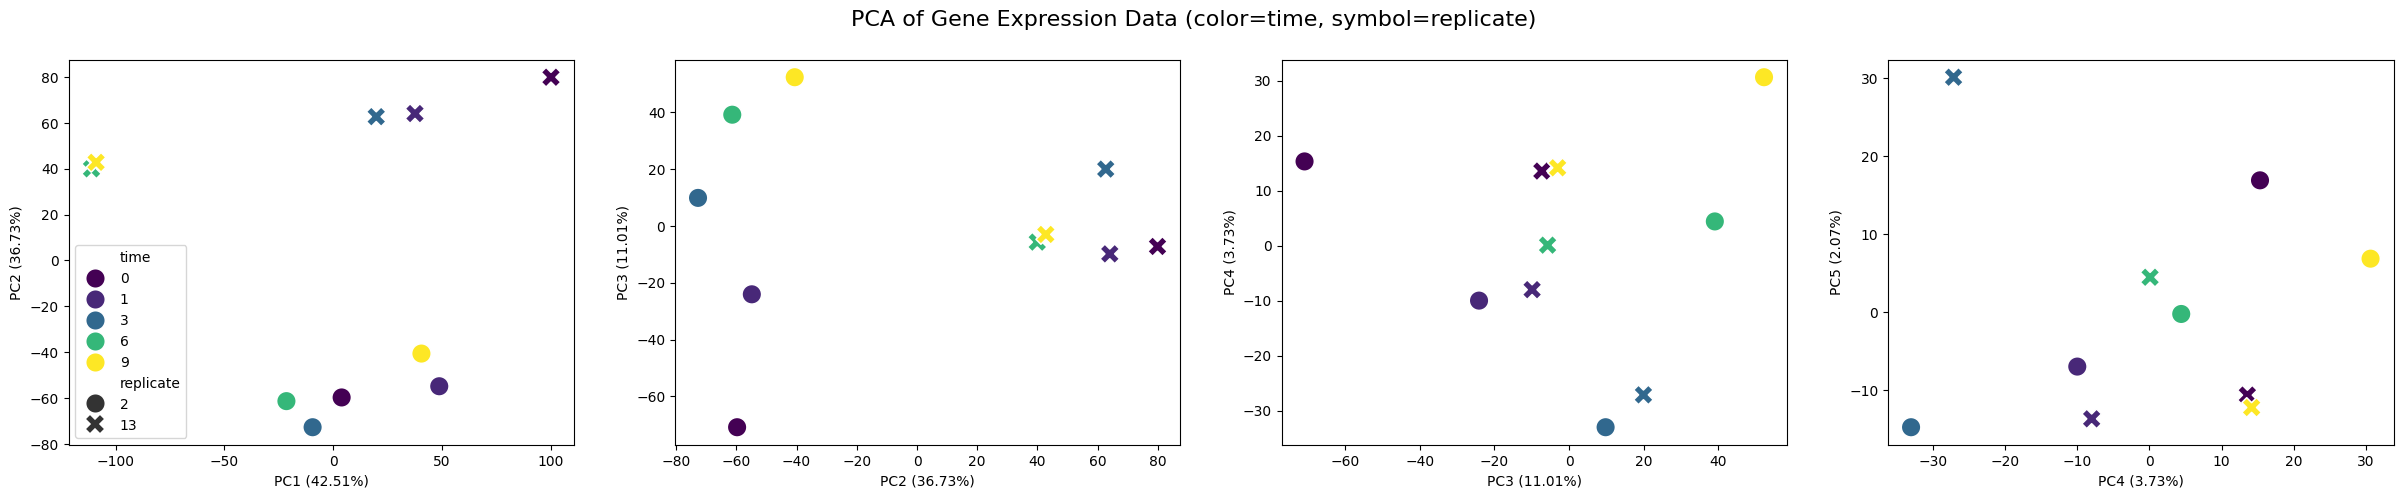

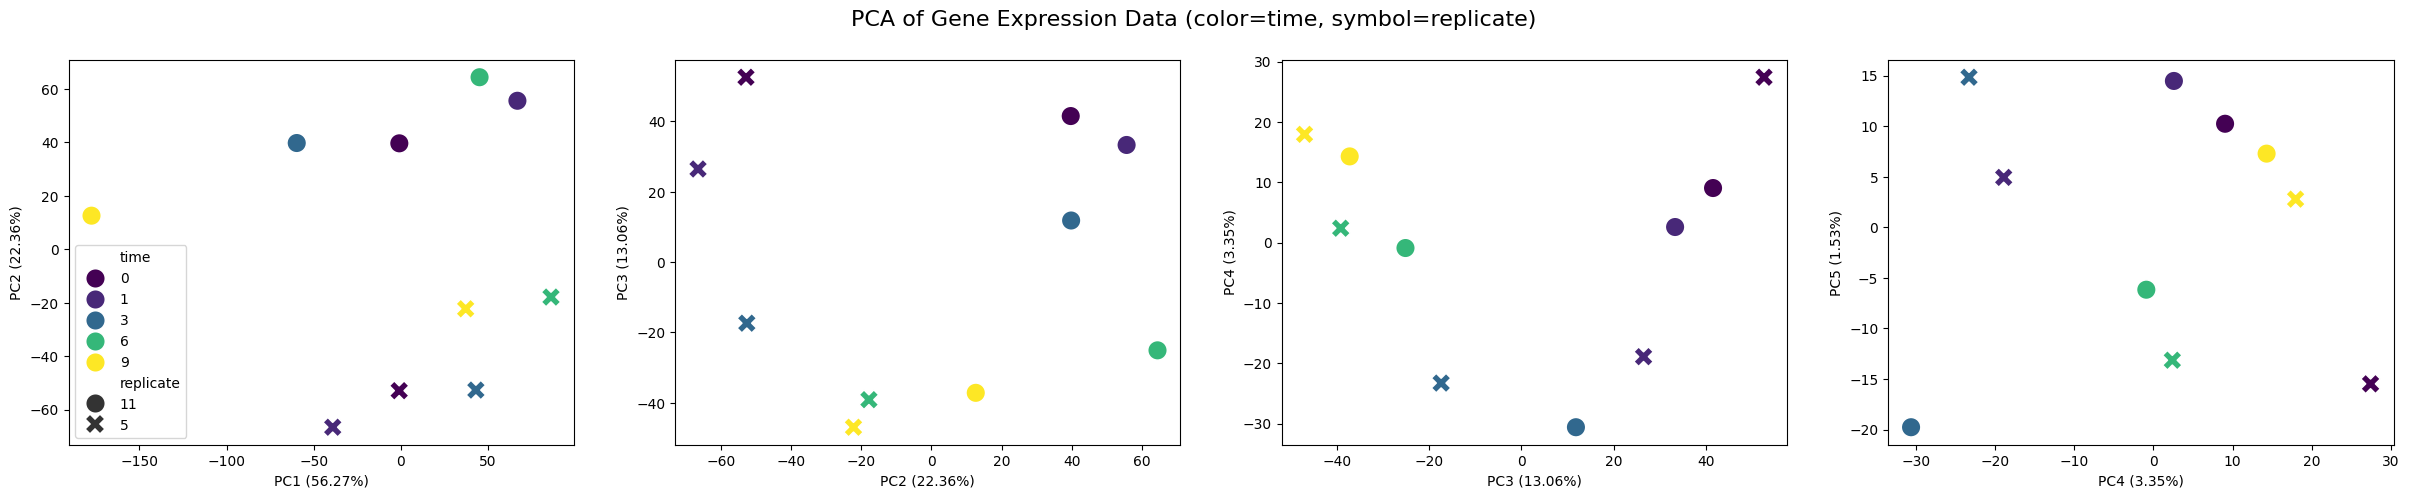

In [13]:
#Choose the features, conditions, replicates, and time points to include in the analysis for the different questions.
time= ['0', '1' ,'3' ,'6', '9']
replicate = ['2', '13', '11', '5'] # replicates 13 and 2 are from the 33to38 experiment, 5 and 11 from the 38to33.
feature = [ 'exon']

#Subselect the samples 

condition = ['33to38']
dat_sub_33_38 = dat_all.loc[:, idx[condition, time, replicate, feature]]
condition = ['38to33']
dat_sub_38_33 = dat_all.loc[:, idx[condition, time, replicate, feature]]


#Perform the PCA, plot, and return the PCA loadings. Adjust the parameters color_by and symbol_by to answer to the different question.
PC_loadings_33_38 = run_PCA(dat_sub_33_38, n_components=5, color_by='time', symbol_by='replicate', scale_data=True, log_transform=True) #upshift
PC_loadings_38_33 = run_PCA(dat_sub_38_33, n_components=5, color_by='time', symbol_by='replicate', scale_data=True, log_transform=True) #downshift

### Question 2
In this exercise, we will explore the RNA-seq data to find genes whose expression levels change in response to temperature shifts (i.e. *Cirbp* is known to be cold-inducible). We will use an approach to directly identify genes that are differentially expressed (DE) when cells are moved from one temperature to another. Modify only the *DE cell* below.

1.1. Use the function *plot_DE* to visualize genes with a change in expression between 33°C and 38°C. Look for genes with patterns similar to or opposite that of *Cirbp* — that is, those that are upregulated (cold-inducible) or downregulated (heat-inducible) when temperature decreases. 

1.2. Using the *plot_gene* function, show the temporal dynamic of genes identified as having temperature-dependent regulation of gene expression.


2.1. Use the function *plot_DE* to highlight genes that are regulated after transcription (i.e. post-transcriptionally) by temperature changes. These genes may show differential expression at the mRNA level that are not seen at the pre-mRNA level. 

2.2. Using the *plot_gene* function, show the temporal dynamic of some of those genes. What can you say in terms of transcriptional versus post-transcriptional regulation?  


*Hint: Be aware that the FC_type argument of the plot_DE function allows you to either:*
- *Highlight genes with 'extreme' fold changes (FC_type = 'delta')*
- *Highlight genes that out of the diagonal (FC_type = 'delta_delta')*

3.1. Looking at the temporal dynamic of Cirbp during temperature shifts at the intronic and exonic level, what can you say about its regulation?  

### Answer 2

**1.** One approach is to plot the fold change between the steady-state (t=0) and the endpoint (t=9) for both conditions at the mRNA level. This method enables us to identify heat-induced and cold-induced transcripts (including Cirbp), which behave "similarly" in both conditions. It's worth noting that the heat-shock genes begin to decrease a few hours after induction in one replicate of the 33to38 condition (indicating a transient induction), and are thus not displayed in the plot. See code below.

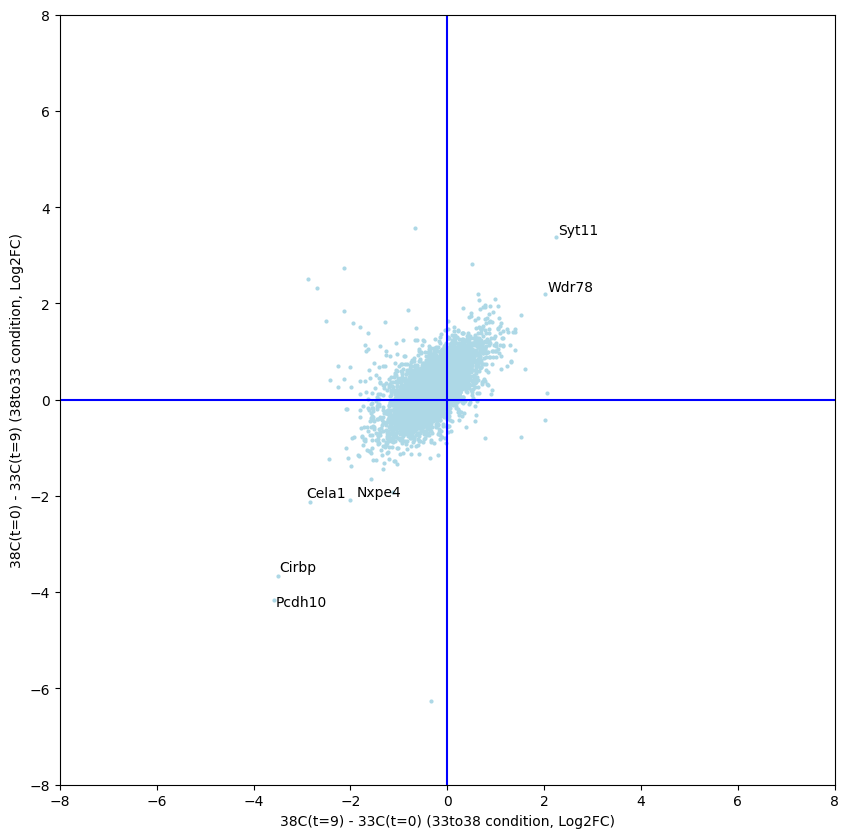

In [14]:
DE_genes = plot_DE(dat_all, condition_x1=['33to38'], condition_x2=['33to38'], condition_y1=['38to33'], condition_y2=['38to33'], # modify the condition parameters ['33to38'], ['38to33']
                time_x1=['0'], time_x2=['9'], time_y1=['9'], time_y2=['0'], # modify the time parameters ['0'], ['1'], ['3'], ['6'], ['9']
                feature_x1=['exon'], feature_x2=['exon'], feature_y1=['exon'], feature_y2=['exon'], # modify the feature parameters ['intron'], ['exon']
                FC=2, # adapt the FC threshold for readibility
                xlab='38C(t=9) - 33C(t=0) (33to38 condition, Log2FC)',
                ylab='38C(t=0) - 33C(t=9) (38to33 condition, Log2FC)',
                FC_type="delta") # this allows to select the type of fold change to use for the plot ("delta" or "delta_delta", extremities or out-of-diagonal)

**1.2.**

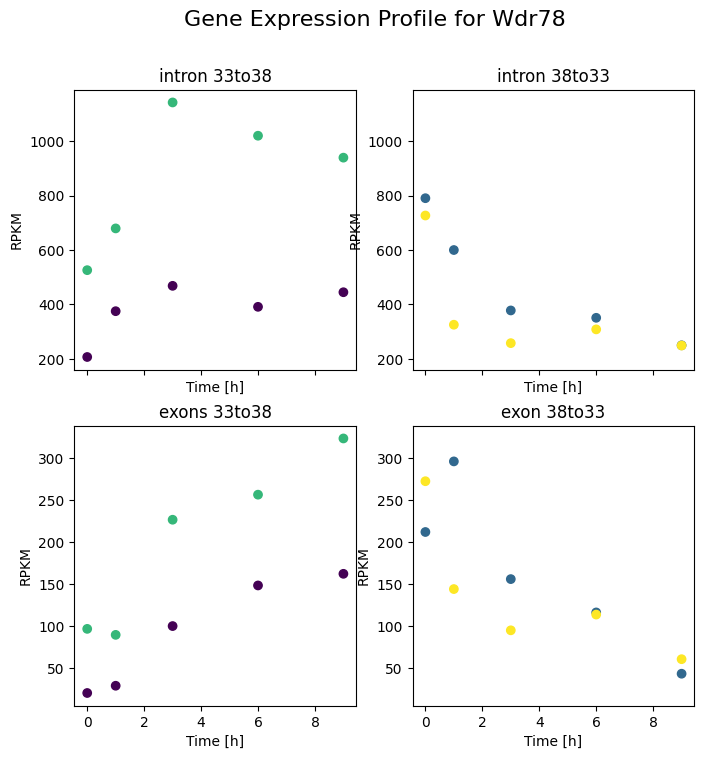

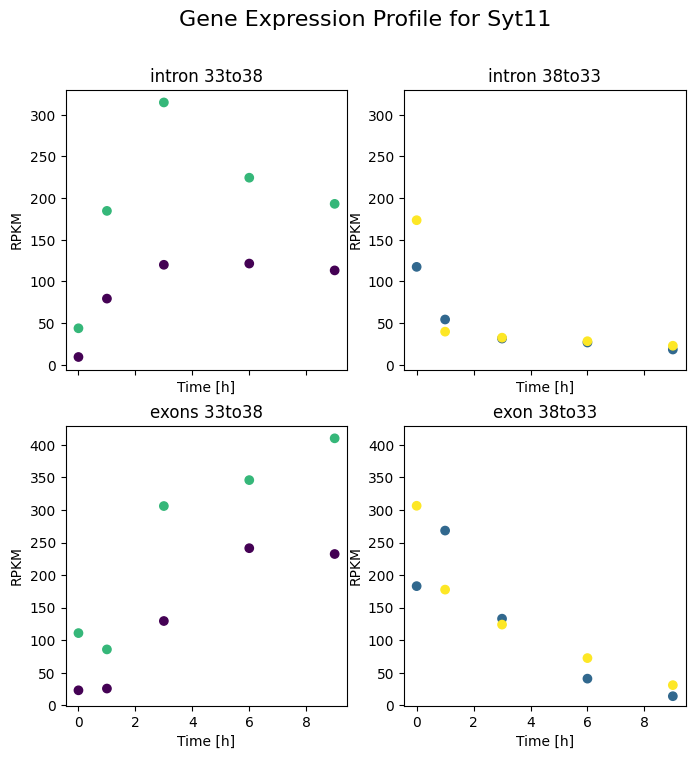

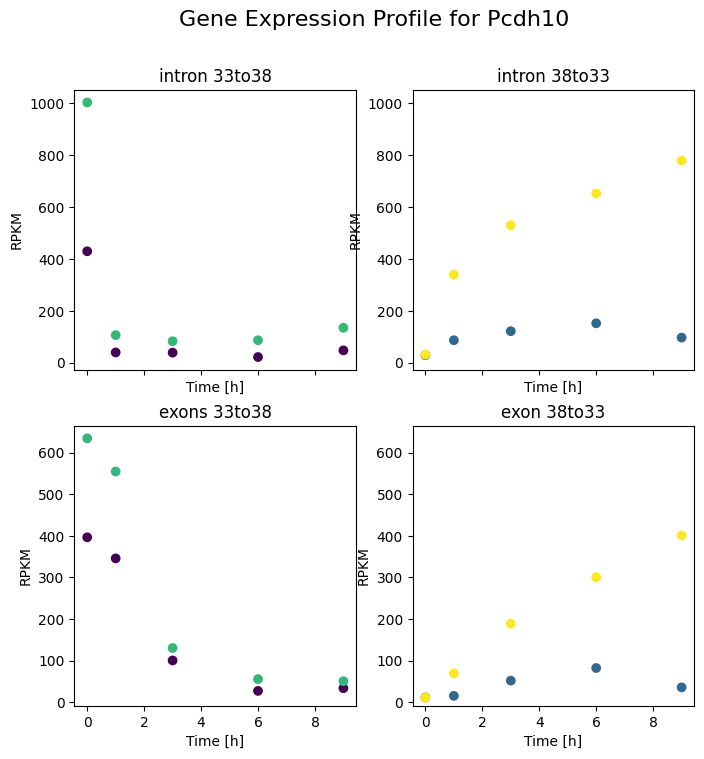

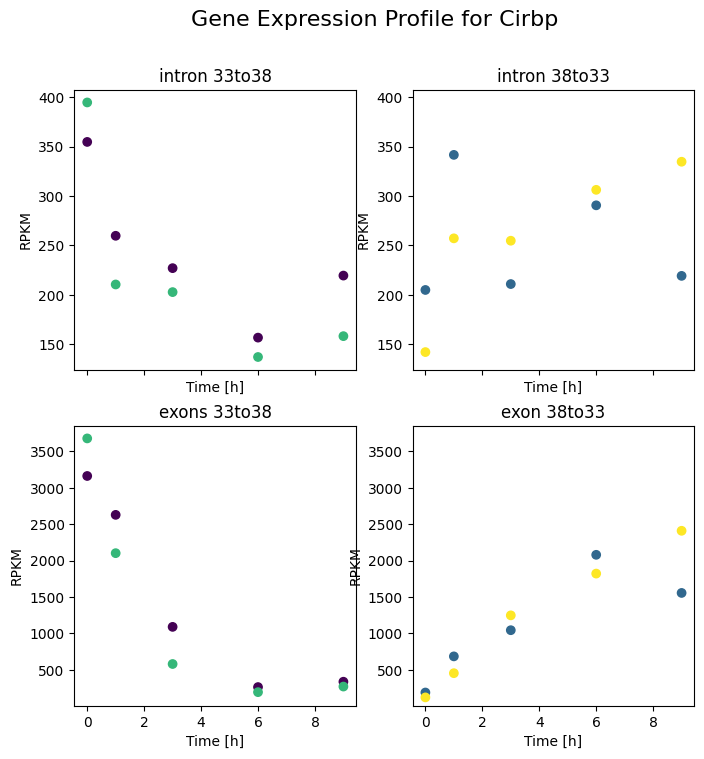

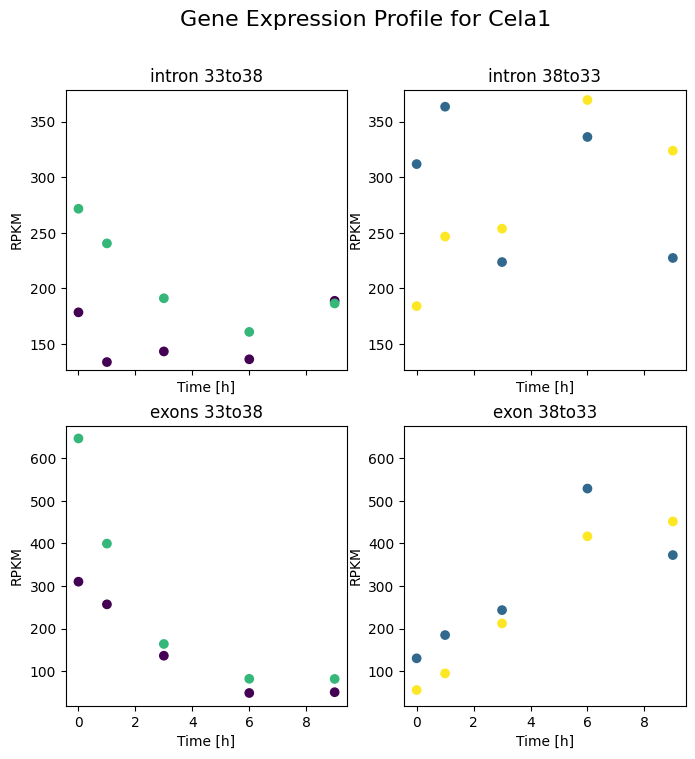

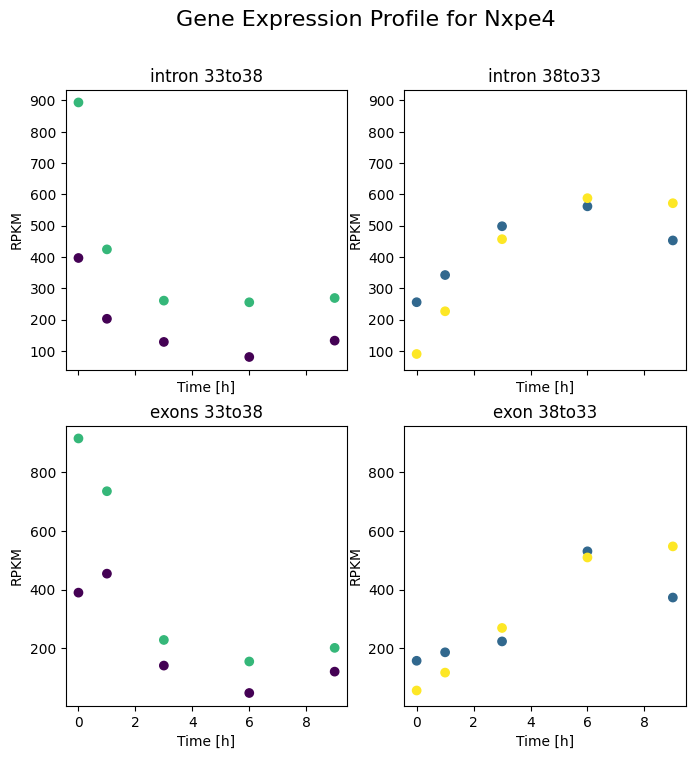

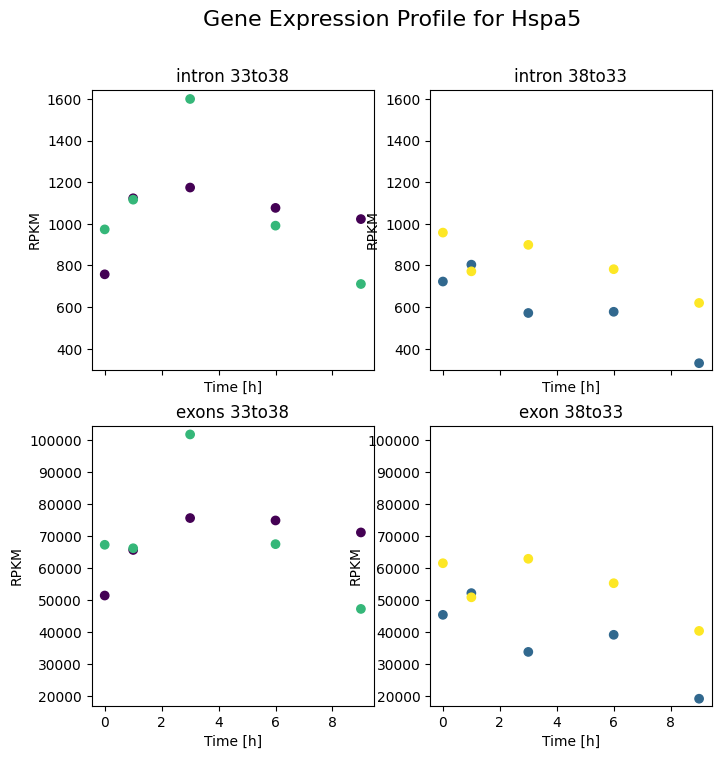

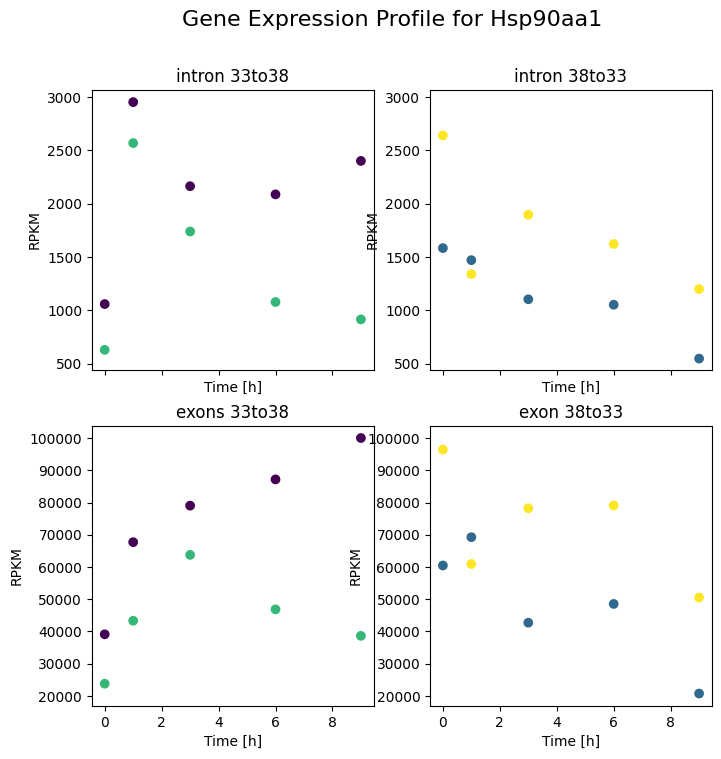

In [41]:
plot_gene(dat_all, 'Wdr78')
plot_gene(dat_all, 'Syt11') #heat-induced
plot_gene(dat_all,"Pcdh10") 
plot_gene(dat_all,"Cirbp") #cold-induced
plot_gene(dat_all,"Cela1") 
plot_gene(dat_all,"Nxpe4") 
plot_gene(dat_all,"Hspa5") #Heat shock gene
plot_gene(dat_all,"Hsp90aa1") #Heat shock gene

**2.1.** One possibility is to compare the ratio (mRNA/pre-mRNA) at steady-state (t=0) between the two conditions. 
We can modify the *FC_type* parameter to highlight genes with different ratios between conditions (i.e. genes that are out of the diagonal). 

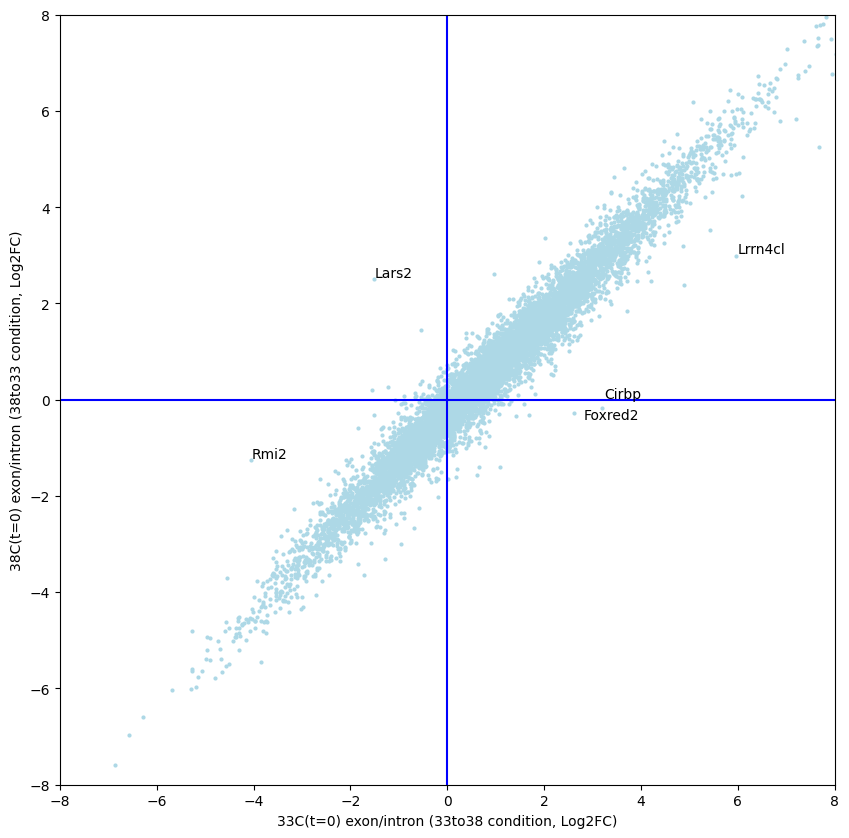

In [16]:
DE_genes = plot_DE(dat_all, condition_x1=['33to38'], condition_x2=['33to38'], condition_y1=['38to33'], condition_y2=['38to33'], # modify the condition parameters ['33to38'], ['38to33']
                time_x1=['0'], time_x2=['0'], time_y1=['0'], time_y2=['0'], # modify the time parameters ['0'], ['1'], ['3'], ['6'], ['9']
                feature_x1=['intron'], feature_x2=['exon'], feature_y1=['intron'], feature_y2=['exon'], # modify the feature parameters ['intron'], ['exon']
                FC=2.5, # adapt the FC threshold for readibility
                xlab='33C(t=0) exon/intron (33to38 condition, Log2FC)',
                ylab='38C(t=0) exon/intron (38to33 condition, Log2FC)',
                FC_type="delta_delta") # this allows to select the type of fold change to use for the plot ("delta" or "delta_delta", extremities or out-of-diagonal)


**2.2.** Genes in the diagonal are regulated transcriptionally (*e.g. Syt11, Pcdh10*) exhibiting increasing or decreasing intronic and exonic levels, whereas others are regulated post-transcriptionally, shown by different dynamics between the intronic levels and exonic levels (*e.g. Cirpb, Foxred2*).

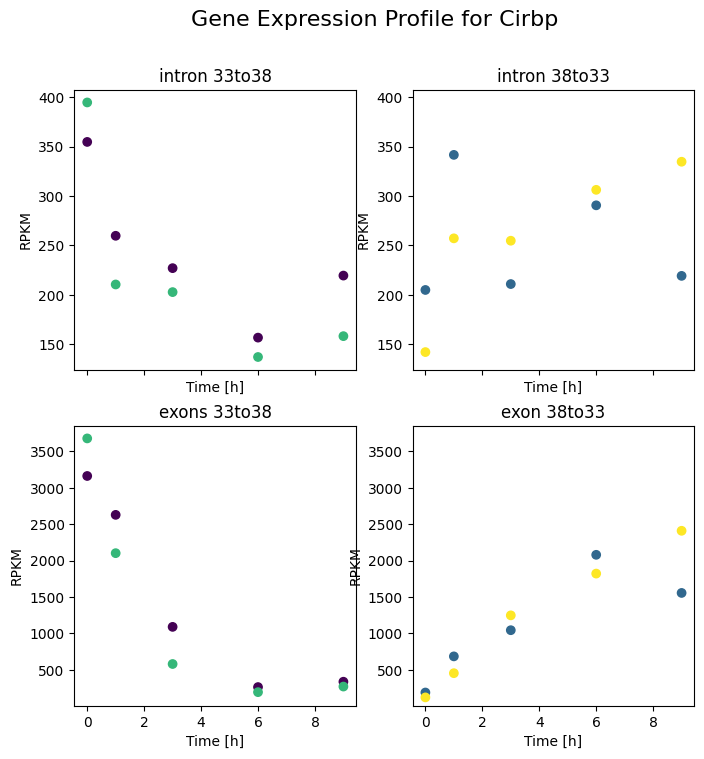

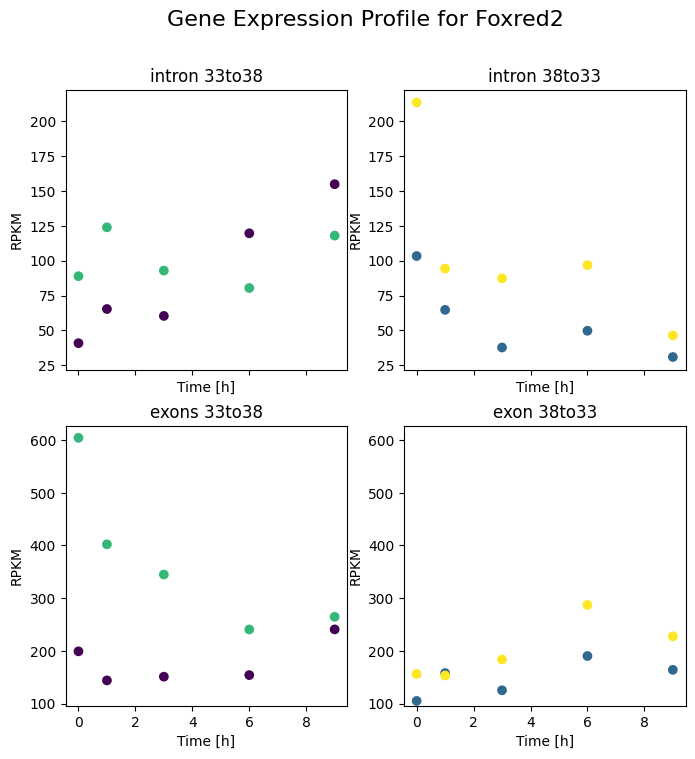

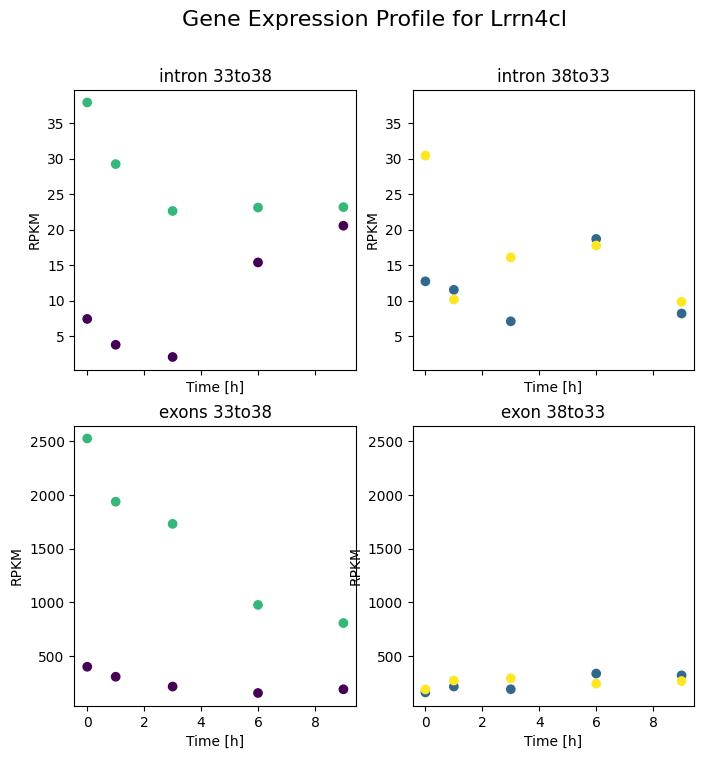

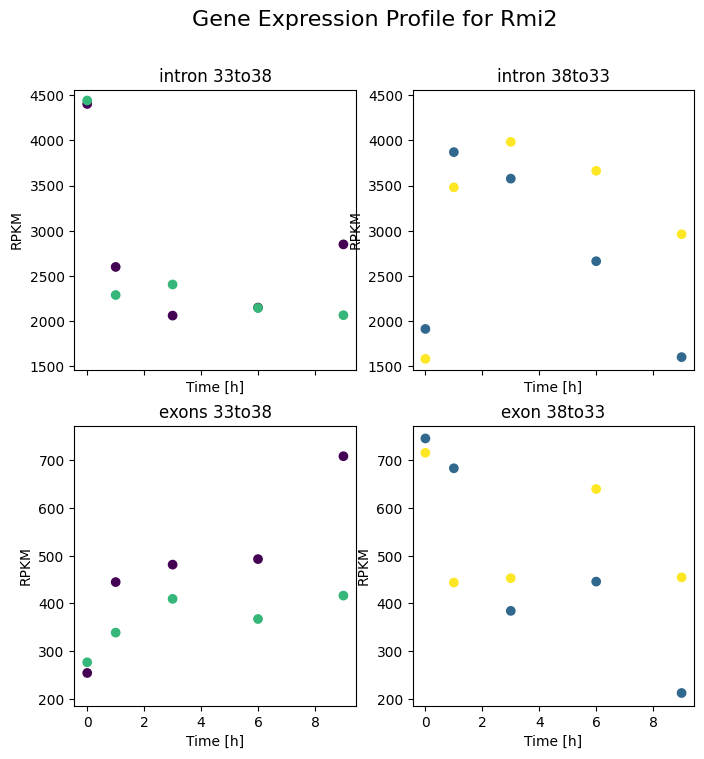

In [52]:
plot_gene(dat_all, 'Cirbp')
plot_gene(dat_all, 'Foxred2')
plot_gene(dat_all, 'Lrrn4cl')
plot_gene(dat_all, 'Rmi2')


**3.1**

*Cirbp* intronic counts are constant, while exonic counts have inverse relation to temperature. This indicates regulation at the post-transcriptional level. 

### Question 3

We will now simulate the production decay model from Question 1 again, but with a temperature shift (i.e. temperature-dependent parameters).

1. Using the widget provided below, simulate the ODE with distinct parameters for the two temperatures. Comment on the outcome.

2. Use the widget to determine the parameters ($\rho_{33}$, $\rho_{38}$, $k_{m,33}$, $k_{m,38}$) that best fit *Cirbp* gene expression profile. Comment on your result.  

3. *Optional*: replace *Cirbp* with other genes identified previously as regulated post-transcriptionally. You might want to change the parameters and limits of the y-scale. Comment on your results. 


*Note: For simplification, compared to the model in the paper, we have used a model without the $\alpha$ parameter, which is still adequate for fitting most gene expression profiles. However, a limitation of this simplified model is that the obtained parameters may not be entirely realistic, which is the argument the authors used to favor the model with the $\alpha$ parameter.*

### Answer 3

**1/2.** Based on the publication and the described regulation of *Cirbp*, we set the parameters as follows: $k_{m,33}=0.151$, $k_{m,38}=0.466$, $rho_{33}=1.65$, $rho_{38}=0.34$. Upon the shift to cold-temperature, splicing rate is strongly increased and degradation rate is slightly decreased.



#### Implementation of the functions for the simulation with a temperature shift

In [11]:
def production_decay_ode_2(y, time, s, kp, km, rho):

    """
    Defines the ODEs for the production and decay of pre-mRNA and mRNA.
    P: pre-mRNA concentration
    M: mRNA concentration
    s: transcription rate (constant)
    kp: pre-mRNA degradation rate
    km: mRNA degradation rate
    rho: splicing rate

    """
    
    P, M = y
    dPdt = s - (kp + rho) * P
    dMdt = rho * P - km * M
    
    return [dPdt, dMdt] 


def compute_ss_param(s, kp, km, rho):
    """
    Compute the steady-state concentrations of pre-mRNA and mRNA (P_ss and M_ss) given the parameters of the model.

    """
    P_ss = s / (kp + rho)
    M_ss = (rho / km) * (s / kp + rho)
    return [P_ss, M_ss]  

def simulation_2(ode_function, parameters, initial_conditions = None, time = None):

    """
    Simulate the ODEs for the production and decay of pre-mRNA and mRNA.
    parameters: parameters for the ODEs
    initial_conditions: initial conditions for the ODEs
    time: time intervals for the simulation
    """

    s=parameters['s']
    kp=parameters['kp']
    km=parameters['km']
    rho=parameters['rho']

    xx=odeint(ode_function, initial_conditions, time, args=(s, kp, km, rho))
    
    return(xx)

def animate_2(time, s_33=6250, s_38=4250, km_33=0.151, km_38=0.466, kp= 20.794, rho_33=1.65, rho_38=0.34, gene='Cirbp'):
    
    """
    Runs the simulation with interactive widgets for parameter exploration and using the steady-state of each temperature condition as initial condition to simulate the switch.
    """

    #33 to 38
    initial_conditions = compute_ss_param(s_33, kp, km_33, rho_33)
    parameters = {'s':s_38,'km':km_38, 'kp':kp, 'rho':rho_38}
    xx_33_38 = simulation_2(production_decay_ode_2, parameters, initial_conditions, time)
    
    #38 to 33
    initial_conditions = compute_ss_param(s_38, kp, km_38, rho_38)

    parameters = {'s':s_33,'km':km_33, 'kp':kp, 'rho':rho_33}
    xx_38_33 = simulation_2(production_decay_ode_2, parameters, initial_conditions, time)
    
   
    plot_gene(dat_all, gene, xx_33_38, xx_38_33, time)    

#### Run the simulation

In [ ]:
t = np.linspace(0,9,9*3600)
interact(animate_2, time=fixed(t), gene = 'Cirbp',
         s_33 = (500,10000,1), # [RPKM/hr] at 33C
         s_38 = (500,10000,1), # [RPKM/hr] at 38C
         km_33 = (0.05,2,0.05), # [hr^-1], you have to find the correct km_33 
         km_38 = (0.05,2,0.05), # [hr^-1], you have to find the correct km_38 
         kp = (0.05,24,0.1),  # [hr^-1], around 2min for Cirbp
         rho_33 = (0.05,5,0.1), # [hr^-1],  you have to find the correct rho_33 
         rho_38 = (0.05,5,0.1)); # [hr^-1], you have to find the correct rho_38

interactive(children=(IntSlider(value=6250, description='s_33', max=10000, min=500), IntSlider(value=4250, des…